In [1]:
import warnings
warnings.filterwarnings('ignore')
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, classification_report
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [21]:
train = pd.read_csv("train.csv")
test = pd.read_csv('test.csv')

In [6]:
non_binaries = [col for col in train.columns if len(train[col].unique().tolist())>2]
binaries = [col for col in train.columns if not col in non_binaries]

In [22]:
x = train.drop('Activity', axis=1)
y = train.Activity
# split data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=42)

In [16]:
y_train.value_counts(normalize=True)

1    0.534476
0    0.465524
Name: Activity, dtype: float64

In [17]:
y_test.value_counts(normalize=True)

1    0.560391
0    0.439609
Name: Activity, dtype: float64

In [4]:
# fit model no training data
def fit_eval(X_train,y_train,X_test,y_test, model,early_stopping=0):
    eval_set = [(X_train, y_train), (X_test, y_test)]
    if early_stopping>0:
        model.fit(X_train, y_train, eval_metric=["logloss"],early_stopping_rounds=early_stopping,eval_set=eval_set, verbose=False)
    else:
        model.fit(X_train, y_train, eval_metric=["logloss"],eval_set=eval_set, verbose=False)
    # make predictions for test data
    y_pred = model.predict(X_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    print(classification_report(y_test, y_pred))

    # retrieve performance metrics
    results = model.evals_result()
    epochs = len(results['validation_0']['logloss'])
    x_axis = range(0, epochs)
    # plot log loss
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
    ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
    ax.legend()
    plt.ylabel('Log Loss')
    plt.title('XGBoost Log Loss')
    plt.show()

In [ ]:
model = XGBClassifier()
fit_eval(X_train,y_train,X_test,y_test, model)

In [13]:
model = XGBClassifier(n_estimators = 200, max_depth = 5,reg_alpha = 5, reg_lambda = 8,learning_rate=0.005)
# fit_eval(X_train,y_train,X_test,y_test, model)

Accuracy: 79.48%
              precision    recall  f1-score   support

           0       0.77      0.77      0.77       495
           1       0.82      0.82      0.82       631

    accuracy                           0.79      1126
   macro avg       0.79      0.79      0.79      1126
weighted avg       0.79      0.79      0.79      1126



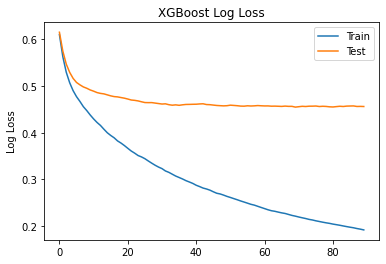

In [39]:
fit_eval(X_train,y_train,X_test,y_test, model, early_stopping=20)

In [15]:
from sklearn.model_selection import StratifiedKFold

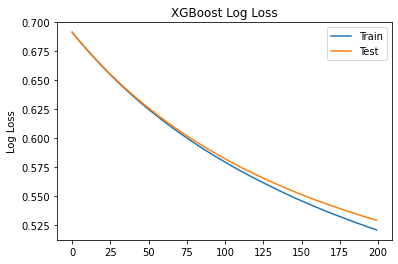

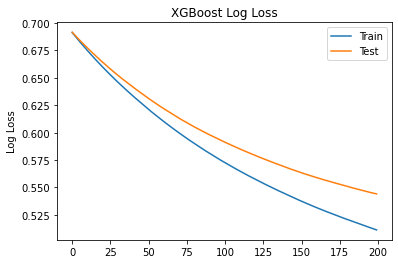

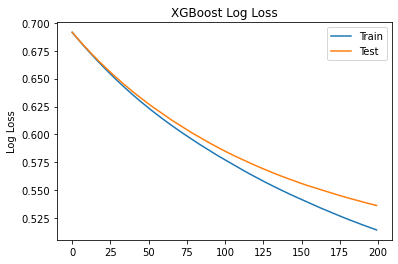

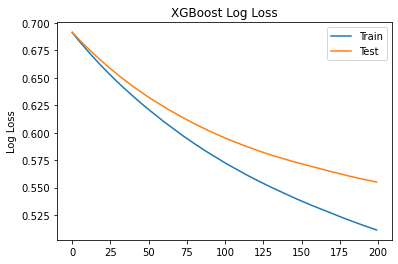

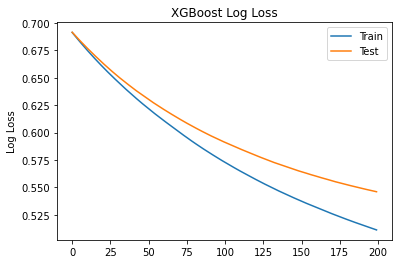

In [23]:
kf = StratifiedKFold(n_splits=5,random_state=42, shuffle=True)
CV_score_array    =[]
for train_index, test_index in kf.split(x,y):
    X_tr, X_valid = x.values[train_index], x.values[test_index]
    y_tr, y_valid = y.values[train_index], y.values[test_index]

    model.fit(X_tr,y_tr,
               eval_set=[(X_tr, y_tr), (X_valid, y_valid)],
               eval_metric=["logloss"], 
               verbose=False)

    results = model.evals_result()
    epochs = len(results['validation_0']['logloss'])
    x_axis = range(0, epochs)
    # plot log loss
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
    ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
    ax.legend()
    plt.ylabel('Log Loss')
    plt.title('XGBoost Log Loss')
    plt.show()  
                        
    CV_score_array.append(model.score(X_valid,y_valid))

In [ ]:
pca = PCA(acp, random_state=42).fit(X_train)
X_train, X_test = pca.transform(X_train), pca.transform(X_test)

## Submission

In [234]:
probas = model.predict_proba(test)[:,1]
submission = pd.DataFrame({'MoleculeId':[x for x in range(1,len(test)+1)],'PredictedProbability':probas})
submission.to_csv('submission_xgboost_regul.csv',index=False)